In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
%reload_ext autoreload

In [127]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import my_types, homography, warp, rectification, utils

In [128]:
DATA = Path("data")

# Pick Correspondences

In [140]:
im1 = my_types.to_img_arr("data/doll1.jpg")
im2 = my_types.to_img_arr("data/doll2.jpg")
im3 = my_types.to_img_arr("data/doll3.jpg")

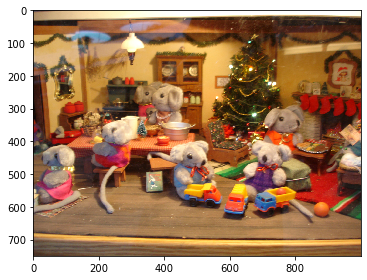

In [141]:
io.imshow(im2)

In [142]:
PICK_NEW = False
im1_name = DATA / "doll1.jpg"
im2_name = DATA / "doll2.jpg"

if PICK_NEW:
    %matplotlib tk
    # im3_name = DATA / "doll3.jpg"
    im1_pts = utils.pick_points(im1_name, 8)
    im2_pts = utils.pick_points(im2_name, 8)
    # im3_pts = utils.pick_points(im3_name, 8)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)
    # utils.save_points(im3_pts, im3_name)
else:
    %matplotlib inline
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
    # im3_pts = utils.load_points(im3_name)

In [143]:
im1_pts

array([[710.53896104, 651.69155844],
       [712.56818182, 511.67532468],
       [720.68506494, 398.03896104],
       [864.75974026, 300.63636364],
       [803.88311688, 288.46103896],
       [970.27922078, 499.5       ],
       [588.78571429, 576.61038961],
       [548.2012987 , 462.97402597]])

In [144]:
im2_pts

array([[235.7012987 , 615.16558442],
       [247.87662338, 475.14935065],
       [243.81818182, 365.57142857],
       [393.98051948, 264.11038961],
       [347.30844156, 260.05194805],
       [479.20779221, 442.68181818],
       [124.09415584, 554.28896104],
       [ 69.30519481, 444.71103896]])

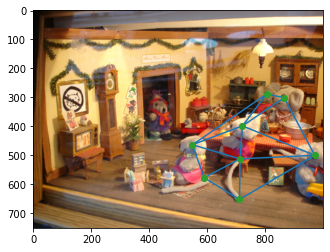

In [156]:
triangulation = warp.delaunay(im1_pts)
warp.plot_tri_mesh(im1, im1_pts, triangulation)

In [289]:
# find homographic transformation matrix
T = homography.homo_matrix(im1_pts, im2_pts)
T

num_pts = 8
(16, 8)
(16,)


array([[ 1.16973903e+00, -4.41763292e-02, -5.34308084e+02],
       [-6.91450044e-03,  1.09612772e+00, -1.11329462e+01],
       [ 2.12107232e-04, -1.93414405e-05,  1.00000000e+00]])

In [287]:
import cv2
T, *_ = cv2.findHomography(im1_pts, im2_pts)
T

array([[ 1.48898902e+00,  5.58042103e-03, -7.22616885e+02],
       [ 7.82864297e-02,  1.41988665e+00, -1.13865899e+02],
       [ 4.46616118e-04,  1.55935124e-04,  1.00000000e+00]])

(900, 1200, 3)
0 0
749 999
(900, 1200, 3)
-534.3080839224654 -534.3625955940057
1.0 1.0
(750, 1000, 3)
749 999


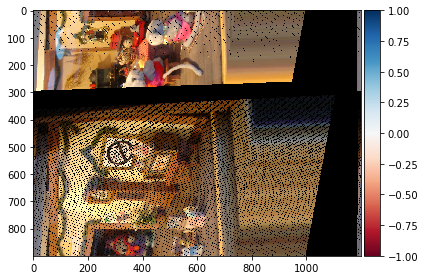

In [290]:
warp1 = homography.warp(im1, T)
io.imshow(warp1)